In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBRegressor
from scipy import stats

In [7]:
df = pd.read_table('CAF308.txt', sep = '\t', na_values= 'NA')
first_valid_index = df.iloc[:, 3:].notna().any(axis=1).idxmax()
df_trimmed_top = df.iloc[first_valid_index:].reset_index(drop=True)
df_trimmed_top.head()

,Location,Date,Time,VW_30cm,VW_60cm,VW_90cm,VW_120cm,VW_150cm,T_30cm,T_60cm,T_90cm,T_120cm,T_150cm
0,CAF308,05/07/2007,17:00,0.306,0.434,0.469,0.445,0.408,10.5,8.4,7.9,7.5,7.3
1,CAF308,05/07/2007,18:00,0.306,0.434,0.469,0.446,0.407,10.6,8.4,7.9,7.5,7.3
2,CAF308,05/07/2007,19:00,0.307,0.434,0.469,0.445,0.408,10.8,8.4,7.9,7.5,7.3
3,CAF308,05/07/2007,20:00,0.307,0.434,0.469,0.445,0.408,11.0,8.4,7.9,7.5,7.3
4,CAF308,05/07/2007,21:00,0.307,0.434,0.469,0.446,0.408,11.2,8.4,7.9,7.5,7.3


In [8]:
last_valid_index = df_trimmed_top.iloc[:, 2:].notna().any(axis=1)[::-1].idxmax()
df_final_trimmed = df_trimmed_top.iloc[:last_valid_index + 1].reset_index(drop=True)
df_final_trimmed.to_csv('CAF308_trimmed_test.csv', index=False)

In [10]:
df_final_trimmed.isnull().sum()

Location        0
Date            0
Time            0
VW_30cm     18381
VW_60cm     23276
VW_90cm     21898
VW_120cm    24115
VW_150cm    25152
T_30cm      18381
T_60cm      23280
T_90cm      21905
T_120cm     24115
T_150cm     25153
dtype: int64

In [11]:
df_final_trimmed.isnull().sum().sum()

225656

In [12]:
num_rows_left = df_final_trimmed.shape[0]
print(f"Number of rows left after cleaning: {num_rows_left}")

Number of rows left after cleaning: 79879


In [13]:
df_final_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79879 entries, 0 to 79878
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Location  79879 non-null  object 
 1   Date      79879 non-null  object 
 2   Time      79879 non-null  object 
 3   VW_30cm   61498 non-null  float64
 4   VW_60cm   56603 non-null  float64
 5   VW_90cm   57981 non-null  float64
 6   VW_120cm  55764 non-null  float64
 7   VW_150cm  54727 non-null  float64
 8   T_30cm    61498 non-null  float64
 9   T_60cm    56599 non-null  float64
 10  T_90cm    57974 non-null  float64
 11  T_120cm   55764 non-null  float64
 12  T_150cm   54726 non-null  float64
dtypes: float64(10), object(3)
memory usage: 7.9+ MB


In [14]:
data = pd.read_csv('CAF308_trimmed_test.csv')

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

data = data.drop(columns=['Date'])

label_encoder = LabelEncoder()
data['Location'] = label_encoder.fit_transform(data['Location'])

columns_to_fill = data.columns.difference(['VW_30cm'])
numeric_columns = data.select_dtypes(include=['number']).columns

for column in numeric_columns:
    if data[column].isna().any():
        columns_to_fill_temp = numeric_columns.difference([column])
        data[columns_to_fill_temp] = data[columns_to_fill_temp].fillna(data[columns_to_fill_temp].median())
        
        data_missing = data[data[column].isna()]
        data_not_missing = data[~data[column].isna()]
        
        features = numeric_columns.difference([column])
        X = data_not_missing[features]
        y = data_not_missing[column]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
        model.fit(X_train, y_train)
        
        X_missing = data_missing[features]
        predicted_values = model.predict(X_missing)
        data.loc[data[column].isna(), column] = predicted_values

data.to_csv('CAF308_cleaned_xgb_complete.csv', index=False)

In [15]:
df=pd.read_csv('CAF308_cleaned_xgb_complete.csv')
df.head()

,Location,Time,VW_30cm,VW_60cm,VW_90cm,VW_120cm,VW_150cm,T_30cm,T_60cm,T_90cm,T_120cm,T_150cm,Day,Month,Year
0,0,17:00,0.306,0.434,0.469,0.445,0.408,10.5,8.4,7.9,7.5,7.3,7,5,2007
1,0,18:00,0.306,0.434,0.469,0.446,0.407,10.6,8.4,7.9,7.5,7.3,7,5,2007
2,0,19:00,0.307,0.434,0.469,0.445,0.408,10.8,8.4,7.9,7.5,7.3,7,5,2007
3,0,20:00,0.307,0.434,0.469,0.445,0.408,11.0,8.4,7.9,7.5,7.3,7,5,2007
4,0,21:00,0.307,0.434,0.469,0.446,0.408,11.2,8.4,7.9,7.5,7.3,7,5,2007


In [16]:
df.isnull().sum()

Location    0
Time        0
VW_30cm     0
VW_60cm     0
VW_90cm     0
VW_120cm    0
VW_150cm    0
T_30cm      0
T_60cm      0
T_90cm      0
T_120cm     0
T_150cm     0
Day         0
Month       0
Year        0
dtype: int64

In [17]:
data = pd.read_csv('CAF308_cleaned_xgb_complete.csv')
data['Location'] = label_encoder.inverse_transform(data['Location'])

data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']]).dt.strftime('%m/%d/%Y')

data = data.drop(columns=['Day', 'Month', 'Year'])

correct_column_order = ['Location', 'Date', 'Time', 'VW_30cm', 'VW_60cm', 'VW_90cm', 'VW_120cm', 'VW_150cm', 
                        'T_30cm', 'T_60cm', 'T_90cm', 'T_120cm', 'T_150cm']

data = data[correct_column_order]

data.to_csv('CAF308_final_cleaned_xgb_complete.csv', index=False)

data.head()

,Location,Date,Time,VW_30cm,VW_60cm,VW_90cm,VW_120cm,VW_150cm,T_30cm,T_60cm,T_90cm,T_120cm,T_150cm
0,CAF308,05/07/2007,17:00,0.306,0.434,0.469,0.445,0.408,10.5,8.4,7.9,7.5,7.3
1,CAF308,05/07/2007,18:00,0.306,0.434,0.469,0.446,0.407,10.6,8.4,7.9,7.5,7.3
2,CAF308,05/07/2007,19:00,0.307,0.434,0.469,0.445,0.408,10.8,8.4,7.9,7.5,7.3
3,CAF308,05/07/2007,20:00,0.307,0.434,0.469,0.445,0.408,11.0,8.4,7.9,7.5,7.3
4,CAF308,05/07/2007,21:00,0.307,0.434,0.469,0.446,0.408,11.2,8.4,7.9,7.5,7.3


Index(['Location', 'Date', 'Time', 'VW_30cm', 'VW_60cm', 'VW_90cm', 'VW_120cm',
       'VW_150cm', 'T_30cm', 'T_60cm', 'T_90cm', 'T_120cm', 'T_150cm'],
      dtype='object')


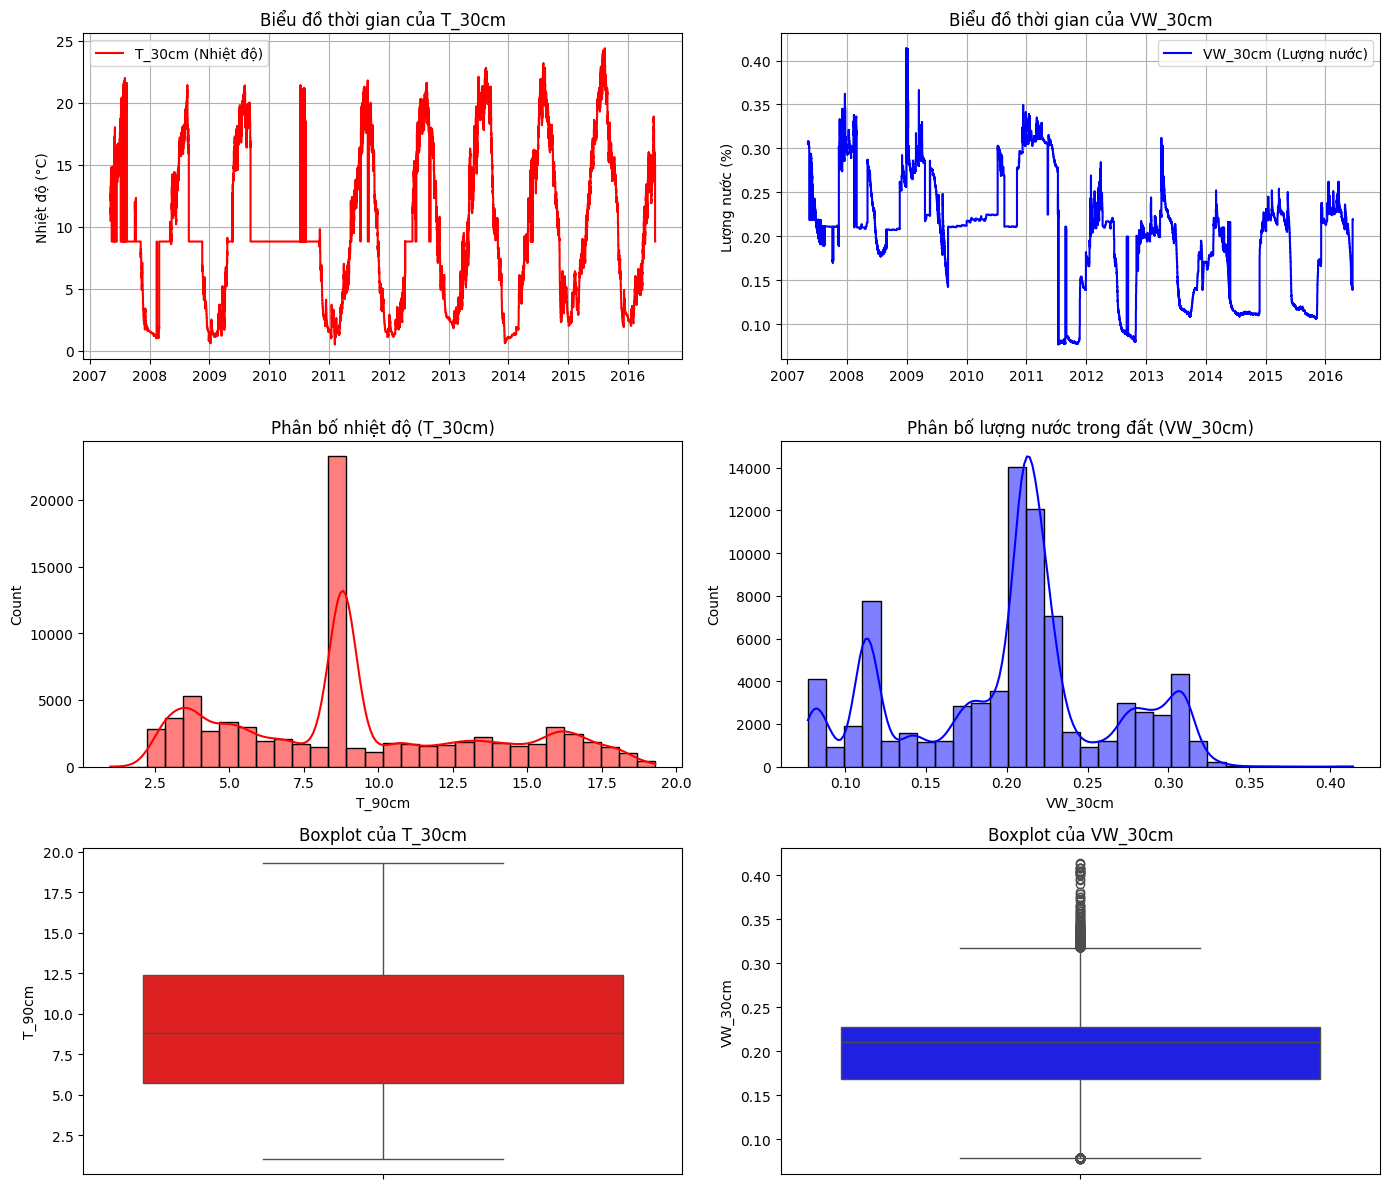

In [ ]:
df_filled = pd.read_csv('CAF308_final_cleaned_xgb_complete.csv')
print(df_filled.columns)  

df_filled["Date"] = pd.to_datetime(df_filled["Date"])

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].plot(df_filled["Date"], df_filled["T_30cm"], label="T_30cm (Nhiệt độ)", color="red")
axes[0, 0].set_ylabel("Nhiệt độ (°C)")
axes[0, 0].set_title("Biểu đồ thời gian của T_30cm")
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(df_filled["Date"], df_filled["VW_30cm"], label="VW_30cm (Lượng nước)", color="blue")
axes[0, 1].set_ylabel("Lượng nước (%)")
axes[0, 1].set_title("Biểu đồ thời gian của VW_30cm")
axes[0, 1].legend()
axes[0, 1].grid(True)

sns.histplot(df_filled["T_90cm"], bins=30, kde=True, ax=axes[1, 0], color="red")
axes[1, 0].set_title("Phân bố nhiệt độ (T_30cm)")

sns.histplot(df_filled["VW_30cm"], bins=30, kde=True, ax=axes[1, 1], color="blue")
axes[1, 1].set_title("Phân bố lượng nước trong đất (VW_30cm)")

sns.boxplot(y=df_filled["T_90cm"], ax=axes[2, 0], color="red")
axes[2, 0].set_title("Boxplot của T_30cm")

sns.boxplot(y=df_filled["VW_30cm"], ax=axes[2, 1], color="blue")
axes[2, 1].set_title("Boxplot của VW_30cm")

plt.tight_layout()
plt.show()


# Temperature

Preprocessing v2.0 w/ MinMax Scaler 

In [38]:
data = pd.read_csv('CAF308_final_cleaned_xgb_complete.csv')

data = data.dropna()

features = data.drop(columns=['Date', 'Location', 'Time', 'T_30cm'])
targets = data['T_30cm']

X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

Train: (39939, 9), Validation: (19970, 9), Test: (19970, 9)
Training set size: 39939
Validation set size: 19970
Testing set size: 19970


In [ ]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train)

y_val_pred_knn = knn.predict(X_val)

mse_knn = mean_squared_error(y_val, y_val_pred_knn)
rmse_knn = np.sqrt(mse_knn)  # Root Mean Squared Error
mae_knn = mean_absolute_error(y_val, y_val_pred_knn)  # Mean Absolute Error
r2_knn = r2_score(y_val, y_val_pred_knn)
fsd_knn = rmse_knn / np.std(y_val)  # Fraction of Standard Deviation
similarity_knn = np.dot(y_val, y_val_pred_knn) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_knn, y_val_pred_knn)))  # Cosine similarity

print(f"KNN - Validation Metrics:")
print(f"MSE: {mse_knn}")
print(f"RMSE: {rmse_knn}")
print(f"MAE: {mae_knn}")
print(f"R2: {r2_knn}")
print(f"FSD: {fsd_knn}")
print(f"Similarity: {similarity_knn}")

y_test_pred_knn = knn.predict(X_test)

mse_knn_test = mean_squared_error(y_test, y_test_pred_knn)
rmse_knn_test = np.sqrt(mse_knn_test)
mae_knn_test = mean_absolute_error(y_test, y_test_pred_knn)
r2_knn_test = r2_score(y_test, y_test_pred_knn)
fsd_knn_test = rmse_knn_test / np.std(y_test)
similarity_knn_test = np.dot(y_test, y_test_pred_knn) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_knn, y_test_pred_knn)))

print(f"\nKNN - Test Metrics:")
print(f"MSE: {mse_knn_test}")
print(f"RMSE: {rmse_knn_test}")
print(f"MAE: {mae_knn_test}")
print(f"R2: {r2_knn_test}")
print(f"FSD: {fsd_knn_test}")
print(f"Similarity: {similarity_knn_test}")

KNN - Validation Metrics:
MSE: 0.07835711567351028
RMSE: 0.27992341037060525
MAE: 0.11918377566349524
R2: 0.9979041926629849
FSD: 0.045779988390289836
Similarity: 0.999698009123328

KNN - Test Metrics:
MSE: 0.08539625438157235
RMSE: 0.2922263752325795
MAE: 0.11842764146219328
R2: 0.997694012327982
FSD: 0.0480207004532204
Similarity: 0.9996693235327769


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_val_pred_lr = lr.predict(X_val)

mse_lr = mean_squared_error(y_val, y_val_pred_lr)
rmse_lr = np.sqrt(mse_lr)  
mae_lr = mean_absolute_error(y_val, y_val_pred_lr)  
r2_lr = r2_score(y_val, y_val_pred_lr)

fsd_lr = rmse_lr / np.std(y_val)

similarity_lr = np.dot(y_val, y_val_pred_lr) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_lr, y_val_pred_lr)))

print(f"Linear Regression - Validation Metrics:")
print(f"MSE: {mse_lr}")
print(f"RMSE: {rmse_lr}")
print(f"MAE: {mae_lr}")
print(f"R2: {r2_lr}")
print(f"FSD: {fsd_lr}")
print(f"Similarity: {similarity_lr}")

y_test_pred_lr = lr.predict(X_test)

mse_lr_test = mean_squared_error(y_test, y_test_pred_lr)
rmse_lr_test = np.sqrt(mse_lr_test)
mae_lr_test = mean_absolute_error(y_test, y_test_pred_lr)
r2_lr_test = r2_score(y_test, y_test_pred_lr)
fsd_lr_test = rmse_lr_test / np.std(y_test)
similarity_lr_test = np.dot(y_test, y_test_pred_lr) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_lr, y_test_pred_lr)))

print(f"\nLinear Regression - Test Metrics:")
print(f"MSE: {mse_lr_test}")
print(f"RMSE: {rmse_lr_test}")
print(f"MAE: {mae_lr_test}")
print(f"R2: {r2_lr_test}")
print(f"FSD: {fsd_lr_test}")
print(f"Similarity: {similarity_lr_test}")

Linear Regression - Validation Metrics:
MSE: 3.054571696021554
RMSE: 1.7477333023151884
MAE: 1.1862205347669206
R2: 0.9182997776662067
FSD: 0.28583250748260464
Similarity: 0.9881466519577234

Linear Regression - Test Metrics:
MSE: 3.1681384887747686
RMSE: 1.7799265402748419
MAE: 1.1985015811747923
R2: 0.9144495463967727
FSD: 0.29249009146162086
Similarity: 0.9876541253847948


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

svr = SVR()

svr.fit(X_train, y_train)

y_val_pred_svr = svr.predict(X_val)

mse_svr = mean_squared_error(y_val, y_val_pred_svr)
rmse_svr = np.sqrt(mse_svr)  
mae_svr = mean_absolute_error(y_val, y_val_pred_svr)  
r2_svr = r2_score(y_val, y_val_pred_svr)
fsd_svr = rmse_svr / np.std(y_val)  
similarity_svr = np.dot(y_val, y_val_pred_svr) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_svr, y_val_pred_svr)))  

print(f"SVM - Validation Metrics:")
print(f"MSE: {mse_svr}")
print(f"RMSE: {rmse_svr}")
print(f"MAE: {mae_svr}")
print(f"R2: {r2_svr}")
print(f"FSD: {fsd_svr}")
print(f"Similarity: {similarity_svr}")

y_test_pred_svr = svr.predict(X_test)

mse_svr_test = mean_squared_error(y_test, y_test_pred_svr)
rmse_svr_test = np.sqrt(mse_svr_test)
mae_svr_test = mean_absolute_error(y_test, y_test_pred_svr)
r2_svr_test = r2_score(y_test, y_test_pred_svr)
fsd_svr_test = rmse_svr_test / np.std(y_test)
similarity_svr_test = np.dot(y_test, y_test_pred_svr) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_svr, y_test_pred_svr)))

print(f"\nSVM - Test Metrics:")
print(f"MSE: {mse_svr_test}")
print(f"RMSE: {rmse_svr_test}")
print(f"MAE: {mae_svr_test}")
print(f"R2: {r2_svr_test}")
print(f"FSD: {fsd_svr_test}")
print(f"Similarity: {similarity_svr_test}")

SVM - Validation Metrics:
MSE: 0.49882962241364437
RMSE: 0.7062787143993824
MAE: 0.37343181151078764
R2: 0.9866578705253644
FSD: 0.11550813596727988
Similarity: 0.9980760525683877

SVM - Test Metrics:
MSE: 0.4997057456157566
RMSE: 0.7068986812943964
MAE: 0.3760515025506304
R2: 0.9865062549010918
FSD: 0.11616258045906255
Similarity: 0.9980659423948246


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict(X_val)

mse_rf = mean_squared_error(y_val, y_val_pred_rf)
rmse_rf = np.sqrt(mse_rf)  # Root Mean Squared Error
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)  # Mean Absolute Error
r2_rf = r2_score(y_val, y_val_pred_rf)
fsd_rf = rmse_rf / np.std(y_val)  # Fraction of Standard Deviation
similarity_rf = np.dot(y_val, y_val_pred_rf) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_rf, y_val_pred_rf)))  # Cosine similarity

print(f"Random Forest - Validation Metrics:")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")
print(f"MAE: {mae_rf}")
print(f"R2: {r2_rf}")
print(f"FSD: {fsd_rf}")
print(f"Similarity: {similarity_rf}")

y_test_pred_rf = rf.predict(X_test)

mse_rf_test = mean_squared_error(y_test, y_test_pred_rf)
rmse_rf_test = np.sqrt(mse_rf_test)
mae_rf_test = mean_absolute_error(y_test, y_test_pred_rf)
r2_rf_test = r2_score(y_test, y_test_pred_rf)
fsd_rf_test = rmse_rf_test / np.std(y_test)
similarity_rf_test = np.dot(y_test, y_test_pred_rf) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_rf, y_test_pred_rf)))

print(f"\nRandom Forest - Test Metrics:")
print(f"MSE: {mse_rf_test}")
print(f"RMSE: {rmse_rf_test}")
print(f"MAE: {mae_rf_test}")
print(f"R2: {r2_rf_test}")
print(f"FSD: {fsd_rf_test}")
print(f"Similarity: {similarity_rf_test}")

Random Forest - Validation Metrics:
MSE: 0.042998572957310834
RMSE: 0.20736097259925945
MAE: 0.09052565351404411
R2: 0.9988499228958274
FSD: 0.033912786735575455
Similarity: 0.999834178012341

Random Forest - Test Metrics:
MSE: 0.03873977519094893
RMSE: 0.19682422409588948
MAE: 0.0889052920304362
R2: 0.9989538950548357
FSD: 0.03234354564923781
Similarity: 0.9998499921495232


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

xgb = XGBRegressor(random_state=42)

xgb.fit(X_train, y_train)

y_val_pred_xgb = xgb.predict(X_val)

mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)  
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)  
r2_xgb = r2_score(y_val, y_val_pred_xgb)
fsd_xgb = rmse_xgb / np.std(y_val)  
similarity_xgb = np.dot(y_val, y_val_pred_xgb) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_xgb, y_val_pred_xgb)))  

print(f"XGBoost - Validation Metrics:")
print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"MAE: {mae_xgb}")
print(f"R2: {r2_xgb}")
print(f"FSD: {fsd_xgb}")
print(f"Similarity: {similarity_xgb}")

y_test_pred_xgb = xgb.predict(X_test)

mse_xgb_test = mean_squared_error(y_test, y_test_pred_xgb)
rmse_xgb_test = np.sqrt(mse_xgb_test)
mae_xgb_test = mean_absolute_error(y_test, y_test_pred_xgb)
r2_xgb_test = r2_score(y_test, y_test_pred_xgb)
fsd_xgb_test = rmse_xgb_test / np.std(y_test)
similarity_xgb_test = np.dot(y_test, y_test_pred_xgb) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_xgb, y_test_pred_xgb)))

print(f"\nXGBoost - Test Metrics:")
print(f"MSE: {mse_xgb_test}")
print(f"RMSE: {rmse_xgb_test}")
print(f"MAE: {mae_xgb_test}")
print(f"R2: {r2_xgb_test}")
print(f"FSD: {fsd_xgb_test}")
print(f"Similarity: {similarity_xgb_test}")

XGBoost - Validation Metrics:
MSE: 0.09166940696951657
RMSE: 0.30276956083714324
MAE: 0.17562852601260018
R2: 0.9975481305806732
FSD: 0.04951635506907603
Similarity: 0.9996464523187872

XGBoost - Test Metrics:
MSE: 0.0888692668443082
RMSE: 0.29810948801456855
MAE: 0.1727067963391706
R2: 0.997600229246021
FSD: 0.04898745506738403
Similarity: 0.9996558292749465


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

lgbm = LGBMRegressor(random_state=42, verbosity=-1)

lgbm.fit(X_train, y_train)

y_val_pred_lgbm = lgbm.predict(X_val)

mse_lgbm = mean_squared_error(y_val, y_val_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)  # Root Mean Squared Error
mae_lgbm = mean_absolute_error(y_val, y_val_pred_lgbm)  # Mean Absolute Error
r2_lgbm = r2_score(y_val, y_val_pred_lgbm)
fsd_lgbm = rmse_lgbm / np.std(y_val)  # Fraction of Standard Deviation
similarity_lgbm = np.dot(y_val, y_val_pred_lgbm) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_lgbm, y_val_pred_lgbm)))  # Cosine similarity

print(f"LightGBM - Validation Metrics:")
print(f"MSE: {mse_lgbm}")
print(f"RMSE: {rmse_lgbm}")
print(f"MAE: {mae_lgbm}")
print(f"R2: {r2_lgbm}")
print(f"FSD: {fsd_lgbm}")
print(f"Similarity: {similarity_lgbm}")

y_test_pred_lgbm = lgbm.predict(X_test)

mse_lgbm_test = mean_squared_error(y_test, y_test_pred_lgbm)
rmse_lgbm_test = np.sqrt(mse_lgbm_test)
mae_lgbm_test = mean_absolute_error(y_test, y_test_pred_lgbm)
r2_lgbm_test = r2_score(y_test, y_test_pred_lgbm)
fsd_lgbm_test = rmse_lgbm_test / np.std(y_test)
similarity_lgbm_test = np.dot(y_test, y_test_pred_lgbm) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_lgbm, y_test_pred_lgbm)))

print(f"\nLightGBM - Test Metrics:")
print(f"MSE: {mse_lgbm_test}")
print(f"RMSE: {rmse_lgbm_test}")
print(f"MAE: {mae_lgbm_test}")
print(f"R2: {r2_lgbm_test}")
print(f"FSD: {fsd_lgbm_test}")
print(f"Similarity: {similarity_lgbm_test}")

LightGBM - Validation Metrics:
MSE: 0.18840539853274588
RMSE: 0.43405690702112537
MAE: 0.25901757849209
R2: 0.9949607458980058
FSD: 0.07098770387887107
Similarity: 0.9992736226575986

LightGBM - Test Metrics:
MSE: 0.17899439695467667
RMSE: 0.4230772943029166
MAE: 0.2553401474822855
R2: 0.9951665459366232
FSD: 0.0695230469943368
Similarity: 0.9993076894177093


# Water Volume

In [46]:
data = pd.read_csv('CAF308_final_cleaned_xgb_complete.csv')

data = data.dropna()

features = data.drop(columns=['Date', 'Location', 'Time', 'VW_30cm'])
targets = data['VW_30cm']

X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

Train: (39939, 9), Validation: (19970, 9), Test: (19970, 9)
Training set size: 39939
Validation set size: 19970
Testing set size: 19970


In [ ]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train)

y_val_pred_knn = knn.predict(X_val)

mse_knn = mean_squared_error(y_val, y_val_pred_knn)
rmse_knn = np.sqrt(mse_knn)  
mae_knn = mean_absolute_error(y_val, y_val_pred_knn)  
r2_knn = r2_score(y_val, y_val_pred_knn)
fsd_knn = rmse_knn / np.std(y_val)  
similarity_knn = np.dot(y_val, y_val_pred_knn) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_knn, y_val_pred_knn)))  

print(f"KNN - Validation Metrics:")
print(f"MSE: {mse_knn}")
print(f"RMSE: {rmse_knn}")
print(f"MAE: {mae_knn}")
print(f"R2: {r2_knn}")
print(f"FSD: {fsd_knn}")
print(f"Similarity: {similarity_knn}")

y_test_pred_knn = knn.predict(X_test)

mse_knn_test = mean_squared_error(y_test, y_test_pred_knn)
rmse_knn_test = np.sqrt(mse_knn_test)
mae_knn_test = mean_absolute_error(y_test, y_test_pred_knn)
r2_knn_test = r2_score(y_test, y_test_pred_knn)
fsd_knn_test = rmse_knn_test / np.std(y_test)
similarity_knn_test = np.dot(y_test, y_test_pred_knn) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_knn, y_test_pred_knn)))

print(f"\nKNN - Test Metrics:")
print(f"MSE: {mse_knn_test}")
print(f"RMSE: {rmse_knn_test}")
print(f"MAE: {mae_knn_test}")
print(f"R2: {r2_knn_test}")
print(f"FSD: {fsd_knn_test}")
print(f"Similarity: {similarity_knn_test}")

KNN - Validation Metrics:
MSE: 9.89653859739811e-06
RMSE: 0.003145876443441177
MAE: 0.0015511375666655604
R2: 0.997463097682112
FSD: 0.0503676713566144
Similarity: 0.9998897421982827

KNN - Test Metrics:
MSE: 1.1706551615002107e-05
RMSE: 0.003421483832345567
MAE: 0.0015985954008606242
R2: 0.997022462142596
FSD: 0.054566820114461144
Similarity: 0.9998707442806851


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_val_pred_lr = lr.predict(X_val)

mse_lr = mean_squared_error(y_val, y_val_pred_lr)
rmse_lr = np.sqrt(mse_lr)  
mae_lr = mean_absolute_error(y_val, y_val_pred_lr) 
r2_lr = r2_score(y_val, y_val_pred_lr)

fsd_lr = rmse_lr / np.std(y_val)

similarity_lr = np.dot(y_val, y_val_pred_lr) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_lr, y_val_pred_lr)))

print(f"Linear Regression - Validation Metrics:")
print(f"MSE: {mse_lr}")
print(f"RMSE: {rmse_lr}")
print(f"MAE: {mae_lr}")
print(f"R2: {r2_lr}")
print(f"FSD: {fsd_lr}")
print(f"Similarity: {similarity_lr}")

y_test_pred_lr = lr.predict(X_test)

mse_lr_test = mean_squared_error(y_test, y_test_pred_lr)
rmse_lr_test = np.sqrt(mse_lr_test)
mae_lr_test = mean_absolute_error(y_test, y_test_pred_lr)
r2_lr_test = r2_score(y_test, y_test_pred_lr)
fsd_lr_test = rmse_lr_test / np.std(y_test)
similarity_lr_test = np.dot(y_test, y_test_pred_lr) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_lr, y_test_pred_lr)))

print(f"\nLinear Regression - Test Metrics:")
print(f"MSE: {mse_lr_test}")
print(f"RMSE: {rmse_lr_test}")
print(f"MAE: {mae_lr_test}")
print(f"R2: {r2_lr_test}")
print(f"FSD: {fsd_lr_test}")
print(f"Similarity: {similarity_lr_test}")

Linear Regression - Validation Metrics:
MSE: 0.0007026337763263471
RMSE: 0.0265072400737298
MAE: 0.01979987602062382
R2: 0.8198851812433402
FSD: 0.42439936234242837
Similarity: 0.9921014213034793

Linear Regression - Test Metrics:
MSE: 0.000715291214467179
RMSE: 0.026744928761677025
MAE: 0.01998032661614585
R2: 0.8180671182951003
FSD: 0.4265359090450647
Similarity: 0.9920306822195589


In [ ]:
svr = SVR()

svr.fit(X_train, y_train)

y_val_pred_svr = svr.predict(X_val)


mse_svr = mean_squared_error(y_val, y_val_pred_svr)
rmse_svr = np.sqrt(mse_svr)  
mae_svr = mean_absolute_error(y_val, y_val_pred_svr)  
r2_svr = r2_score(y_val, y_val_pred_svr)
fsd_svr = rmse_svr / np.std(y_val)  
similarity_svr = np.dot(y_val, y_val_pred_svr) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_svr, y_val_pred_svr)))  

print(f"SVM - Validation Metrics:")
print(f"MSE: {mse_svr}")
print(f"RMSE: {rmse_svr}")
print(f"MAE: {mae_svr}")
print(f"R2: {r2_svr}")
print(f"FSD: {fsd_svr}")
print(f"Similarity: {similarity_svr}")

y_test_pred_svr = svr.predict(X_test)

mse_svr_test = mean_squared_error(y_test, y_test_pred_svr)
rmse_svr_test = np.sqrt(mse_svr_test)
mae_svr_test = mean_absolute_error(y_test, y_test_pred_svr)
r2_svr_test = r2_score(y_test, y_test_pred_svr)
fsd_svr_test = rmse_svr_test / np.std(y_test)
similarity_svr_test = np.dot(y_test, y_test_pred_svr) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_svr, y_test_pred_svr)))

print(f"\nSVM - Test Metrics:")
print(f"MSE: {mse_svr_test}")
print(f"RMSE: {rmse_svr_test}")
print(f"MAE: {mae_svr_test}")
print(f"R2: {r2_svr_test}")
print(f"FSD: {fsd_svr_test}")
print(f"Similarity: {similarity_svr_test}")

SVM - Validation Metrics:
MSE: 0.0025779754366242118
RMSE: 0.050773767209300234
MAE: 0.04047959443340006
R2: 0.33915562534667254
FSD: 0.8129233510321422
Similarity: 0.9734561332784385

SVM - Test Metrics:
MSE: 0.0026048425352796726
RMSE: 0.05103765801131232
MAE: 0.040764267125186944
R2: 0.337463540379227
FSD: 0.813963426463851
Similarity: 0.9730290753307738


In [ ]:

rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict(X_val)

mse_rf = mean_squared_error(y_val, y_val_pred_rf)
rmse_rf = np.sqrt(mse_rf)  
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)  
r2_rf = r2_score(y_val, y_val_pred_rf)
fsd_rf = rmse_rf / np.std(y_val)  
similarity_rf = np.dot(y_val, y_val_pred_rf) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_rf, y_val_pred_rf))) 

print(f"Random Forest - Validation Metrics:")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")
print(f"MAE: {mae_rf}")
print(f"R2: {r2_rf}")
print(f"FSD: {fsd_rf}")
print(f"Similarity: {similarity_rf}")

y_test_pred_rf = rf.predict(X_test)

mse_rf_test = mean_squared_error(y_test, y_test_pred_rf)
rmse_rf_test = np.sqrt(mse_rf_test)
mae_rf_test = mean_absolute_error(y_test, y_test_pred_rf)
r2_rf_test = r2_score(y_test, y_test_pred_rf)
fsd_rf_test = rmse_rf_test / np.std(y_test)
similarity_rf_test = np.dot(y_test, y_test_pred_rf) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_rf, y_test_pred_rf)))

print(f"\nRandom Forest - Test Metrics:")
print(f"MSE: {mse_rf_test}")
print(f"RMSE: {rmse_rf_test}")
print(f"MAE: {mae_rf_test}")
print(f"R2: {r2_rf_test}")
print(f"FSD: {fsd_rf_test}")
print(f"Similarity: {similarity_rf_test}")

Random Forest - Validation Metrics:
MSE: 9.337609917328066e-06
RMSE: 0.0030557503034979914
MAE: 0.0014223382394634304
R2: 0.997606374793604
FSD: 0.048924689129272676
Similarity: 0.9998954650181286

Random Forest - Test Metrics:
MSE: 9.969550378572385e-06
RMSE: 0.0031574594816992326
MAE: 0.0014471536652515262
R2: 0.9974642649133795
FSD: 0.050356082915776396
Similarity: 0.9998893354330189


In [ ]:
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train, y_train)

y_val_pred_xgb = xgb.predict(X_val)

mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)  # Root Mean Squared Error
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)  # Mean Absolute Error
r2_xgb = r2_score(y_val, y_val_pred_xgb)
fsd_xgb = rmse_xgb / np.std(y_val)  # Fraction of Standard Deviation
similarity_xgb = np.dot(y_val, y_val_pred_xgb) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_xgb, y_val_pred_xgb)))  # Cosine similarity

print(f"XGBoost - Validation Metrics:")
print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"MAE: {mae_xgb}")
print(f"R2: {r2_xgb}")
print(f"FSD: {fsd_xgb}")
print(f"Similarity: {similarity_xgb}")

y_test_pred_xgb = xgb.predict(X_test)

mse_xgb_test = mean_squared_error(y_test, y_test_pred_xgb)
rmse_xgb_test = np.sqrt(mse_xgb_test)
mae_xgb_test = mean_absolute_error(y_test, y_test_pred_xgb)
r2_xgb_test = r2_score(y_test, y_test_pred_xgb)
fsd_xgb_test = rmse_xgb_test / np.std(y_test)
similarity_xgb_test = np.dot(y_test, y_test_pred_xgb) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_xgb, y_test_pred_xgb)))

print(f"\nXGBoost - Test Metrics:")
print(f"MSE: {mse_xgb_test}")
print(f"RMSE: {rmse_xgb_test}")
print(f"MAE: {mae_xgb_test}")
print(f"R2: {r2_xgb_test}")
print(f"FSD: {fsd_xgb_test}")
print(f"Similarity: {similarity_xgb_test}")

XGBoost - Validation Metrics:
MSE: 1.144470406787103e-05
RMSE: 0.003383002226997646
MAE: 0.002068154321781803
R2: 0.9970662372513803
FSD: 0.054164220188420174
Similarity: 0.9998713455382161

XGBoost - Test Metrics:
MSE: 1.1946270393560883e-05
RMSE: 0.0034563377140494943
MAE: 0.002080794484757399
R2: 0.9969614901534259
FSD: 0.055122679965456
Similarity: 0.9998668975810017


In [ ]:
lgbm = LGBMRegressor(random_state=42, verbosity=-1)

lgbm.fit(X_train, y_train)

y_val_pred_lgbm = lgbm.predict(X_val)

mse_lgbm = mean_squared_error(y_val, y_val_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)  
mae_lgbm = mean_absolute_error(y_val, y_val_pred_lgbm)  
r2_lgbm = r2_score(y_val, y_val_pred_lgbm)
fsd_lgbm = rmse_lgbm / np.std(y_val)  
similarity_lgbm = np.dot(y_val, y_val_pred_lgbm) / (np.sqrt(np.dot(y_val, y_val)) * np.sqrt(np.dot(y_val_pred_lgbm, y_val_pred_lgbm)))  

print(f"LightGBM - Validation Metrics:")
print(f"MSE: {mse_lgbm}")
print(f"RMSE: {rmse_lgbm}")
print(f"MAE: {mae_lgbm}")
print(f"R2: {r2_lgbm}")
print(f"FSD: {fsd_lgbm}")
print(f"Similarity: {similarity_lgbm}")

y_test_pred_lgbm = lgbm.predict(X_test)

mse_lgbm_test = mean_squared_error(y_test, y_test_pred_lgbm)
rmse_lgbm_test = np.sqrt(mse_lgbm_test)
mae_lgbm_test = mean_absolute_error(y_test, y_test_pred_lgbm)
r2_lgbm_test = r2_score(y_test, y_test_pred_lgbm)
fsd_lgbm_test = rmse_lgbm_test / np.std(y_test)
similarity_lgbm_test = np.dot(y_test, y_test_pred_lgbm) / (np.sqrt(np.dot(y_test, y_test)) * np.sqrt(np.dot(y_test_pred_lgbm, y_test_pred_lgbm)))

print(f"\nLightGBM - Test Metrics:")
print(f"MSE: {mse_lgbm_test}")
print(f"RMSE: {rmse_lgbm_test}")
print(f"MAE: {mae_lgbm_test}")
print(f"R2: {r2_lgbm_test}")
print(f"FSD: {fsd_lgbm_test}")
print(f"Similarity: {similarity_lgbm_test}")

LightGBM - Validation Metrics:
MSE: 1.7610699318423752e-05
RMSE: 0.004196510373920664
MAE: 0.0027465132237870253
R2: 0.9954856313163593
FSD: 0.06718905181382445
Similarity: 0.9998028226164233

LightGBM - Test Metrics:
MSE: 2.072235183785333e-05
RMSE: 0.00455218099792323
MAE: 0.002808318404538781
R2: 0.994729311489766
FSD: 0.07259950764457013
Similarity: 0.9997700052816341
